# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

#### **1.2** Import necessary libraries

In [101]:
# Import warnings
import warnings

warnings.filterwarnings("ignore")

In [102]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations

# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown  # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data

# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import (
    train_test_split,
)  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix

In [103]:
# Ensure pandas displays full content
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [104]:
# define a function to load json file to a dataframe
import json
import pandas as pd


def load_json_dataframe(json_path: str) -> pd.DataFrame:

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [105]:
# read the json file by giving the file path and create a dataframe
# Step 1: Upload JSON file from your computer

# Step 3: Call the function
df = load_json_dataframe("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [106]:
# display first five rows of the dataframe - df
# Step 4: Display few rows
print("Rows:", len(df))
df.head()

Rows: 285


,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [107]:
# print the dimensions of dataframe - df
# Print dimensions of the DataFrame
print("DataFrame dimensions (rows, columns):", df.shape)

DataFrame dimensions (rows, columns): (285, 2)


In [108]:
# print the information of the dataframe
# Print information about the DataFrame
print("DataFrame Information:\n")
display(df.info())

DataFrame Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


None

#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [109]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df["input_tokens"] = df["input"].apply(lambda x: x.split())
# Tokenize POS
df["pos_tokens"] = df["pos"].apply(lambda x: x.split())

In [110]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [111]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df["input_length"] = df["input_tokens"].apply(len)
df["pos_length"] = df["pos_tokens"].apply(len)
df[["input", "input_length", "pos_length"]].head()

,input,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,46,46
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,21,21


In [112]:
# check for the equality of input_length and pos_length in the dataframe
# Check equality of input_length and pos_length
df["length_match"] = df["input_length"] == df["pos_length"]

# Print how many rows are mismatched
mismatch_count = df[~df["length_match"]].shape[0]
print(f"Number of mismatched rows: {mismatch_count}")

# Display mismatched rows (if any)
df[~df["length_match"]].head()

Number of mismatched rows: 5


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,14,False
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Baguette, sliced, 1, 1/2, tablespoon, Butter, 1/2, Garlic, minced, cup, Spinach, Leaves, Palak, Red, Bell, pepper, Capsicum, Tomato, finely, chopped, Onion, Black, powder, Italian, seasoning, teaspoon, Fresh, cream, Cheddar, cheese, grated, Salt, Roasted, tomato, pasta, sauce]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",37,36,False
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Poha, Flattened, rice, 2, tablespoons, Rice, flour, 2, 1/2, liter, Milk, 1, Nolen, Gur, or, brown, sugar, Cardamom, Elaichi, Pods/Seeds, 8-10, Mixed, nuts, almonds/cashews, tablespoon, Raisins, pinch, Saffron, strands, and, a, little, more, for, garnish, Salt]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",38,37,False
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingr

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [113]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Extracts and prints all unique POS labels
    from the 'pos_tokens' column of the DataFrame.
    """
    # Flatten all tag lists into one set of unique labels
    labels = set(tag for tags in df["pos_tokens"] for tag in tags)

    print("Unique POS labels found in the dataset:\n")
    for label in sorted(labels):
        print("-", label)

    return labels


# Call the function
unique_labels(df)

Unique POS labels found in the dataset:

- ingredient
- quantity
- unit


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>Indexes requiring cleaning and formatting:
[12, 47, 68, 89, 113]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [114]:
# drop the irrelevant recipe data
df_cleaned = df[df["input_length"] == df["pos_length"]].reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [115]:
# update the input and pos length in input_length and pos_length
df_cleaned["input_length"] = df_cleaned["input_tokens"].apply(len)
df_cleaned["pos_length"] = df_cleaned["pos_tokens"].apply(len)

# Confirm update
print("Updated token lengths ")
df_cleaned[["input_length", "pos_length"]].head()

Updated token lengths 


,input_length,pos_length
0,31,31
1,34,34
2,37,37
3,46,46
4,21,21


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [116]:
# validate the input length and pos length as input_length and pos_length
# Validate that input_length and pos_length are equal for all rows
mismatch_count = (df_cleaned["input_length"] != df_cleaned["pos_length"]).sum()

if mismatch_count == 0:
    print(" Validation successful: All rows have matching input_length and pos_length.")
else:
    print(f" Validation failed: {mismatch_count} rows still have mismatched lengths.")
    display(
        df_cleaned[df_cleaned["input_length"] != df_cleaned["pos_length"]][
            ["input", "pos", "input_length", "pos_length"]
        ]
    )

 Validation successful: All rows have matching input_length and pos_length.


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [168]:
# split the dataset into training and validation sets

# Split the cleaned dataframe into 70% train and 30% validation
train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
print(f" Data successfully split:")
print(f"Training set: {train_df.shape[0]} rows")
print(f"Validation set: {val_df.shape[0]} rows")

 Data successfully split:
Training set: 196 rows
Validation set: 84 rows


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [118]:
# print the first five rows of train_df

train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
175,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
55,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41,True
109,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25,True
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit,

In [119]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15,True
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56,True
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
259,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingr

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [120]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df["input_tokens"].tolist()
y_train = train_df["pos_tokens"].tolist()

X_val = val_df["input_tokens"].tolist()
y_val = val_df["pos_tokens"].tolist()

# Display dataset sizes
print(f" Training set: {len(X_train)} samples")
print(f" Validation set: {len(X_val)} samples")

# Optional: Preview a small sample
print("\nExample training tokens:\n", [x for x in X_train[0]])
print("\nExample training labels:\n", [y for y in y_train[0]])

 Training set: 196 samples
 Validation set: 84 samples

Example training tokens:
 ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']

Example training labels:
 ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [121]:
# validate the shape of training and validation samples

print("Training set:")
print(f"  Number of samples (sentences): {len(X_train)}")
print(f"  Number of label sequences:     {len(y_train)}")

print("\n Validation set:")
print(f"  Number of samples (sentences): {len(X_val)}")
print(f"  Number of label sequences:     {len(y_val)}")

# Optional: check that each sentence has matching token–label lengths
train_mismatch = sum(len(x) != len(y) for x, y in zip(X_train, y_train))
val_mismatch = sum(len(x) != len(y) for x, y in zip(X_val, y_val))

if train_mismatch == 0 and val_mismatch == 0:
    print(
        "\n Validation successful: All samples have matching token and label lengths."
    )
else:
    print(
        f"\n Found {train_mismatch} mismatched samples in training and {val_mismatch} in validation."
    )

Training set:
  Number of samples (sentences): 196
  Number of label sequences:     196

 Validation set:
  Number of samples (sentences): 84
  Number of label sequences:     84

 Validation successful: All samples have matching token and label lengths.


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [122]:
# Display the number of unique labels present in y_train
# Get all unique labels from y_train
unique_labels = sorted(set(label for seq in y_train for label in seq))

# Display the unique labels and their count
print(f" Number of unique labels in y_train: {len(unique_labels)}\n")
print("Unique labels:", unique_labels)

 Number of unique labels in y_train: 3

Unique labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [169]:
# flatten the list for nested_list (input_tokens, pos_tokens)

flattened_input_tokens = [
    token for tokens in df_cleaned["input_tokens"] for token in tokens
]
flattened_pos_tokens = [tag for tags in df_cleaned["pos_tokens"] for tag in tags]

# Display summary info
print("Flattened input tokens:", len(flattened_input_tokens), "total tokens")
print("Flattened POS tokens:", len(flattened_pos_tokens), "total labels")

# Optional: Show first 20 tokens and tags
print("\nSample tokens:", flattened_input_tokens[:20])
print("\nSample labels:", flattened_pos_tokens[:20])

Flattened input tokens: 9990 total tokens
Flattened POS tokens: 9990 total labels

Sample tokens: ['6', 'Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', '1', 'Onion', '3', 'tablespoon', 'Gram', 'flour', 'besan', '2', 'teaspoons', 'Turmeric', 'powder', 'Haldi', 'Red', 'Chilli']

Sample labels: ['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [171]:
# initialise the dataset_name
dataset_name = "Training"

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [174]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens


def extract_and_validate_tokens(df, dataset_name):

    # Flatten both columns
    flattened_input_tokens = [
        token for tokens in df["input_tokens"] for token in tokens
    ]
    flattened_pos_tokens = [tag for tags in df["pos_tokens"] for tag in tags]

    # Validate lengths
    print(f"{dataset_name} dataset:")
    print("Total input tokens:", len(flattened_input_tokens))
    print("Total POS tokens:", len(flattened_pos_tokens))

    if len(flattened_input_tokens) == len(flattened_pos_tokens):
        print("Validation successful: Input and POS token counts match.\n")
    else:
        print("Validation failed: Mismatch in token counts!\n")

    # Display first 10 token–label pairs
    print("First 10 token–label pairs:\n")
    for token, tag in list(zip(flattened_input_tokens, flattened_pos_tokens))[:10]:
        print(f"{token:<20} {tag}")


# Example usage

extract_and_validate_tokens(df_cleaned, dataset_name)

Training dataset:
Total input tokens: 9990
Total POS tokens: 9990
Validation successful: Input and POS token counts match.

First 10 token–label pairs:

6                    quantity
Karela               ingredient
Bitter               ingredient
Gourd                ingredient
Pavakkai             ingredient
Salt                 ingredient
1                    quantity
Onion                ingredient
3                    quantity
tablespoon           unit


In [126]:
# extract the tokens and its pos tags

tokens = df_cleaned["input_tokens"].tolist()
pos_tags = df_cleaned["pos_tokens"].tolist()

# Display summary
print("Number of token sequences:", len(tokens))
print("Number of POS tag sequences:", len(pos_tags))

# Display the first record for verification
print("\nFirst input_tokens sequence:\n", tokens[0])
print("\nFirst pos_tokens sequence:\n", pos_tags[0])

Number of token sequences: 280
Number of POS tag sequences: 280

First input_tokens sequence:
 ['6', 'Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', '1', 'Onion', '3', 'tablespoon', 'Gram', 'flour', 'besan', '2', 'teaspoons', 'Turmeric', 'powder', 'Haldi', 'Red', 'Chilli', 'Cumin', 'seeds', 'Jeera', 'Coriander', 'Powder', 'Dhania', 'Amchur', 'Dry', 'Mango', 'Sunflower', 'Oil']

First pos_tokens sequence:
 ['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [127]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays


def categorize_tokens(tokens, pos_tags):

    valid_labels = {"ingredient", "unit", "quantity"}

    # Flatten lists in case nested
    flat_tokens = [tok for seq in tokens for tok in seq]
    flat_tags = [tag for seq in pos_tags for tag in seq]

    # Validation check
    unique_tags = set(flat_tags)
    if not unique_tags.issubset(valid_labels):
        print("Validation failed: Unexpected tags found ->", unique_tags - valid_labels)
        return [], [], []

    # Categorize tokens
    ingredients = [
        tok for tok, tag in zip(flat_tokens, flat_tags) if tag == "ingredient"
    ]
    units = [tok for tok, tag in zip(flat_tokens, flat_tags) if tag == "unit"]
    quantities = [tok for tok, tag in zip(flat_tokens, flat_tags) if tag == "quantity"]

    print("Validation successful: All tags are valid.\n")
    print(f"Ingredients: {len(ingredients)} tokens")
    print(f"Units: {len(units)} tokens")
    print(f"Quantities: {len(quantities)} tokens\n")

    return ingredients, units, quantities


# Example usage
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

Validation successful: All tags are valid.

Ingredients: 7430 tokens
Units: 1169 tokens
Quantities: 1391 tokens



In [128]:
#  call the function to categorise the labels into respective list

ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

# Display summary results
print("First 10 ingredients:", ingredients[:10])
print("\nFirst 10 units:", units[:10])
print("\nFirst 10 quantities:", quantities[:10])

Validation successful: All tags are valid.

Ingredients: 7430 tokens
Units: 1169 tokens
Quantities: 1391 tokens

First 10 ingredients: ['Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', 'Onion', 'Gram', 'flour', 'besan', 'Turmeric']

First 10 units: ['tablespoon', 'teaspoons', 'cups', 'teaspoons', 'teaspoon', 'tablespoon', 'cups', 'cup', 'teaspoon', 'sprig']

First 10 quantities: ['6', '1', '3', '2', '2-1/2', '3', '1', '1/2', '2', '1-1/2']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [166]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter
import pandas as pd


def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):

    if not item_list:
        print(f"No items found for label '{pos_label}' in {dataset_name} dataset.")
        return pd.DataFrame(columns=[pos_label, "count"])

    # Count token frequencies
    item_counts = Counter(item_list)
    top_items = item_counts.most_common(top_n)

    # Convert to DataFrame for better readability
    df_top = pd.DataFrame(top_items, columns=[pos_label, "count"])

    print(f"Top {top_n} frequent {pos_label}s in {dataset_name} dataset:\n")
    display(df_top)

    return df_top


# Example usage:
top_ingredients = get_top_frequent_items(ingredients, "ingredient", "Training")
top_units = get_top_frequent_items(units, "unit", "Training")
top_quantities = get_top_frequent_items(quantities, "quantity", "Training")

Top 10 frequent ingredients in Training dataset:



,ingredient,count
0,powder,183
1,Salt,149
2,seeds,125
3,Oil,122
4,Red,120
5,chopped,115
6,Green,115
7,Chilli,113
8,Coriander,98
9,Leaves,94


Top 10 frequent units in Training dataset:



,unit,count
0,teaspoon,221
1,cup,193
2,tablespoon,131
3,tablespoons,93
4,grams,82
5,cups,74
6,inch,72
7,sprig,62
8,teaspoons,57
9,cloves,55


Top 10 frequent quantitys in Training dataset:



,quantity,count
0,1,269
1,2,221
2,1/2,203
3,1/4,139
4,3,98
5,4,87
6,1-1/2,34
7,5,28
8,200,26
9,6,25


In [130]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients = get_top_frequent_items(ingredients, "ingredient", "Training")

Top 10 frequent ingredients in Training dataset:



,ingredient,count
0,powder,183
1,Salt,149
2,seeds,125
3,Oil,122
4,Red,120
5,chopped,115
6,Green,115
7,Chilli,113
8,Coriander,98
9,Leaves,94


In [131]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, "unit", "Training")

Top 10 frequent units in Training dataset:



,unit,count
0,teaspoon,221
1,cup,193
2,tablespoon,131
3,tablespoons,93
4,grams,82
5,cups,74
6,inch,72
7,sprig,62
8,teaspoons,57
9,cloves,55


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [132]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt
import seaborn as sns


def plot_top_items(top_items_df, label, dataset_name):

    if top_items_df.empty:
        print(f"No data available to plot for {label} in {dataset_name} dataset.")
        return

    plt.figure(figsize=(10, 5))
    sns.barplot(x="count", y=label, data=top_items_df, palette="viridis")
    plt.title(
        f"Top {label.capitalize()}s in {dataset_name} Dataset",
        fontsize=14,
        weight="bold",
    )
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel(label.capitalize(), fontsize=12)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



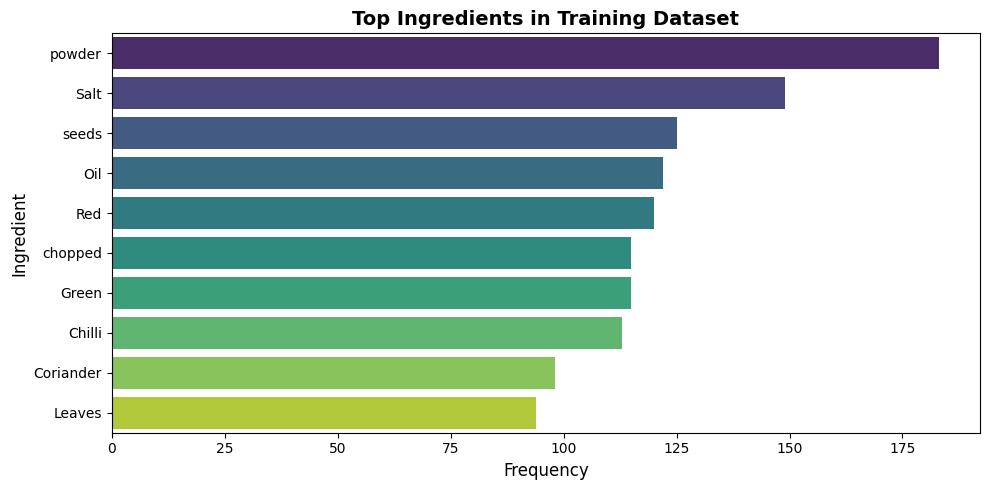

In [133]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "ingredient", "Training")

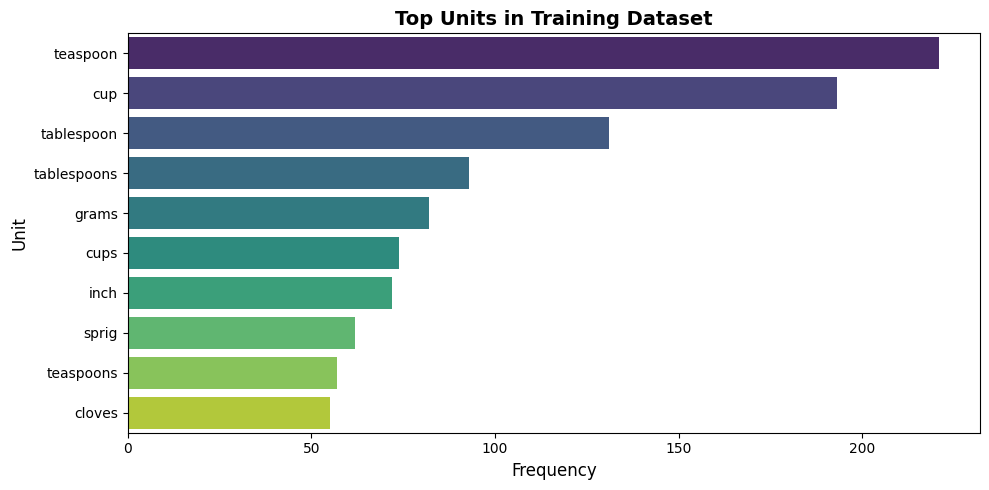

In [134]:
# plot the top frequent units in training data
plot_top_items(top_units, "unit", "Training")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [135]:
# initialise the dataset_name

In [136]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

In [137]:
# plot the top frequent ingredients in validation data

In [138]:
# plot the top frequent units in training data

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [139]:
# define unit and quantity keywords along with quantity pattern

import re

unit_keywords = {
    # spoons/cups
    "tsp",
    "teaspoon",
    "teaspoons",
    "tsp.",
    "tbsp",
    "tablespoon",
    "tablespoons",
    "tbsp.",
    "cup",
    "cups",
    # weight/volume
    "g",
    "gram",
    "grams",
    "gm",
    "gms",
    "kg",
    "kilogram",
    "kilograms",
    "mg",
    "milligram",
    "milligrams",
    "ml",
    "milliliter",
    "milliliters",
    "millilitre",
    "millilitres",
    "l",
    "liter",
    "liters",
    "litre",
    "litres",
    "oz",
    "ounce",
    "ounces",
    "lb",
    "lbs",
    "pound",
    "pounds",
    # small measures / misc
    "pinch",
    "pinches",
    "dash",
    "dashes",
    "drop",
    "drops",
    "sprig",
    "sprigs",
    "bunch",
    "bunches",
    "handful",
    "handfuls",
    "slice",
    "slices",
    "stick",
    "sticks",
    "clove",
    "cloves",
    "piece",
    "pieces",
    # packages
    "packet",
    "packets",
    "pack",
    "packs",
    "can",
    "cans",
    "jar",
    "jars",
}

quantity_keywords = {
    "half",
    "quarter",
    "three-quarter",
    "three-quarters",
    "one-third",
    "two-thirds",
    "third",
    "quarters",
    "few",
    "couple",
    "dozen",
    "dozens",
    "some",
}

# integers/decimals; unicode fractions; simple fractions; mixed numbers; ranges with '-' or 'to'
_unicode_fracs = "¼½¾⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞"
_num = r"(?:\d+(?:\.\d+)?)"
_frac = r"(?:\d+/\d+)"
_unicode = f"[{_unicode_fracs}]"
_mixed = rf"(?:{_num}\s+{_frac})"
_single = rf"(?:{_mixed}|{_frac}|{_num}|{_unicode})"
quantity_pattern = re.compile(
    rf"{_single}(?:\s*(?:-|to)\s*{_single})?", flags=re.UNICODE
)

In [140]:
# load spaCy model
import spacy

# Load the small English spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [176]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

import re

_unicode_fracs = "¼½¾⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞"
_frac_re = re.compile(r"^\d+/\d+$")
_dec_re = re.compile(r"^\d+\.\d+$")
_uni_re = re.compile(rf"^[{_unicode_fracs}]+$")


def is_unit_token(t):
    return t.lower() in unit_keywords


def is_quantity_token(t):
    return bool(quantity_pattern.match(t.lower())) or (t.lower() in quantity_keywords)


def is_numeric_token(t):
    return t.isdigit() or bool(_dec_re.match(t))


def is_fraction_token(t):
    return bool(_frac_re.match(t)) or bool(_uni_re.match(t))


def is_decimal_token(t):
    return bool(_dec_re.match(t))


def word2features(sent, i):
    tok = sent[i]
    txt = tok.text
    low = txt.lower()
    feats = {
        # --- Core Features ---
        "bias": 1.0,
        "token": low,
        "lemma": tok.lemma_.lower(),
        "pos_tag": tok.pos_,
        "tag": tok.tag_,
        "dep": tok.dep_,
        "shape": tok.shape_,
        "is_stop": bool(tok.is_stop),
        "is_digit": txt.isdigit(),
        "has_digit": any(c.isdigit() for c in txt),
        "has_alpha": any(c.isalpha() for c in txt),
        "hyphenated": "-" in txt,
        "slash_present": "/" in txt,
        "is_title": txt.istitle(),
        "is_upper": txt.isupper(),
        "is_punct": bool(tok.is_punct),
        # --- Improved Quantity & Unit Detection ---
        "is_quantity": is_quantity_token(txt),
        "is_unit": is_unit_token(txt),
        "is_numeric": is_numeric_token(txt),
        "is_fraction": is_fraction_token(txt),
        "is_decimal": is_decimal_token(txt),
    }

    # --- Contextual Features ---
    if i > 0:
        p = sent[i - 1]
        ptxt = p.text
        feats.update(
            {
                "prev_token": ptxt.lower(),
                "prev_is_quantity": is_quantity_token(ptxt),
                "prev_is_digit": ptxt.isdigit(),
                "BOS": False,
                "preceding_word": ptxt,
            }
        )
    else:
        feats.update({"BOS": True, "preceding_word": ""})

    if i < len(sent) - 1:
        n = sent[i + 1]
        ntxt = n.text
        nxt_is_unit = is_unit_token(ntxt)
        nxt_is_qty = is_quantity_token(ntxt)
        feats.update(
            {
                "next_token": ntxt.lower(),
                "next_is_unit": nxt_is_unit,
                "next_is_ingredient": (not nxt_is_unit and not nxt_is_qty),
                "EOS": False,
                "following_word": ntxt,
            }
        )
    else:
        feats.update({"EOS": True, "following_word": ""})

    return feats

    # Process the entire sentence with spaCy


def sent2features_spacy_doc(doc):
    return [word2features(doc, i) for i in range(len(doc))]


def sent2features_from_text(text):
    doc = nlp(text)
    feats = [word2features(doc, i) for i in range(len(doc))]
    toks = [t.text for t in doc]
    return toks, feats


# example
sample_text = "Add 1½ cups rice and 2 tablespoons oil."
tokens, feats = sent2features_from_text(sample_text)
print(tokens[:10], feats[0], "\n")

# --- Core Features ---

core_keys = {
    "bias",
    "token",
    "lemma",
    "pos_tag",
    "tag",
    "dep",
    "shape",
    "is_stop",
    "is_digit",
    "has_digit",
    "has_alpha",
    "hyphenated",
    "slash_present",
    "is_title",
    "is_upper",
    "is_punct",
}

core_only = [{k: v for k, v in f.items() if k in core_keys} for f in feats]
print(core_only[:3], "\n")


# --- Improved Quantity & Unit Detection ---

qty_unit_keys = {"is_quantity", "is_unit", "is_numeric", "is_fraction", "is_decimal"}
qty_unit_only = [{k: v for k, v in f.items() if k in qty_unit_keys} for f in feats]
print(list(zip(tokens, qty_unit_only))[:10], "\n")

# --- Contextual Features ---

ctx_keys = {
    "prev_token",
    "prev_is_quantity",
    "prev_is_digit",
    "BOS",
    "next_token",
    "next_is_unit",
    "next_is_ingredient",
    "EOS",
    "preceding_word",
    "following_word",
}

ctx_only = [{k: v for k, v in f.items() if k in ctx_keys} for f in feats]
print(list(zip(tokens, ctx_only))[:10])

['Add', '1½', 'cups', 'rice', 'and', '2', 'tablespoons', 'oil', '.'] {'bias': 1.0, 'token': 'add', 'lemma': 'add', 'pos_tag': 'VERB', 'tag': 'VB', 'dep': 'ROOT', 'shape': 'Xxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': True, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'preceding_word': '', 'next_token': '1½', 'next_is_unit': False, 'next_is_ingredient': False, 'EOS': False, 'following_word': '1½'} 

[{'bias': 1.0, 'token': 'add', 'lemma': 'add', 'pos_tag': 'VERB', 'tag': 'VB', 'dep': 'ROOT', 'shape': 'Xxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': True, 'is_upper': False, 'is_punct': False}, {'bias': 1.0, 'token': '1½', 'lemma': '1½', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'd½',

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [142]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features


def sent2features(sentence):

    from spacy.tokens import Doc, Token

    if isinstance(sentence, str):
        doc = nlp(sentence)
    elif isinstance(sentence, Doc):
        doc = sentence
    elif isinstance(sentence, list) and sentence:
        if isinstance(sentence[0], Token):
            try:
                doc = (
                    sentence[0].doc
                    if sentence[0].doc is not None
                    else nlp(" ".join(t.text for t in sentence))
                )
            except Exception:
                doc = nlp(" ".join(t.text for t in sentence))
        else:
            doc = nlp(" ".join(str(t) for t in sentence))
    else:
        doc = nlp("")

    return [word2features(doc, i) for i in range(len(doc))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [143]:
from spacy.tokens import Doc


def build_doc_from_tokens(tokens):
    doc = Doc(nlp.vocab, words=tokens)
    for _, proc in nlp.pipeline:
        doc = proc(doc)
    return doc


def sent2features_from_tokens(tokens):
    doc = build_doc_from_tokens(tokens)
    return [word2features(doc, i) for i in range(len(doc))]


# Regenerate aligned features using pre-tokenized tokens
X_train_features = [sent2features_from_tokens(tokens) for tokens in X_train]
X_val_features = [sent2features_from_tokens(tokens) for tokens in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [178]:
# Convert labels into list as y_train_labels and y_val_labels

# Since y_train and y_val are already lists of POS tag sequences,
# we can directly assign them to new variables for clarity

y_train_labels = [l for l in y_train]
y_val_labels = [l for l in y_val]

# Display summary
print("Number of training label sequences:", len(y_train_labels))
print("Number of validation label sequences:", len(y_val_labels))

# Optional: preview the first few labels
print("\nSample labels from first training sentence:\n")
print(y_train_labels[0])

# Verify alignment
bad_train = [
    i
    for i, (x, y) in enumerate(zip(X_train_features, y_train_labels))
    if len(x) != len(y)
]
bad_val = [
    i for i, (x, y) in enumerate(zip(X_val_features, y_val_labels)) if len(x) != len(y)
]
print("Mismatched train indices:", bad_train)
print("Mismatched val indices:", bad_val)

Number of training label sequences: 196
Number of validation label sequences: 84

Sample labels from first training sentence:

['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Mismatched train indices: []
Mismatched val indices: []


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [145]:
# print the length of train features and labels

print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

# Optional check — ensure both match
if len(X_train_features) == len(y_train_labels):
    print("Training features and labels are aligned correctly.")
else:
    print("Warning: Mismatch detected between training features and labels.")

Length of X_train_features: 196
Length of y_train_labels: 196
Training features and labels are aligned correctly.


In [146]:
# print the length of validation features and labels

print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

# Optional check — ensure both match
if len(X_val_features) == len(y_val_labels):
    print("Validation features and labels are aligned correctly.")
else:
    print("Warning: Mismatch detected between validation features and labels.")

Length of X_val_features: 84
Length of y_val_labels: 84
Validation features and labels are aligned correctly.


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [147]:
# Flatten labels in y_train


y_train_flat = [label for sequence in y_train_labels for label in sequence]

# Display summary
print("Total flattened labels in y_train_flat:", len(y_train_flat))
print("Sample of flattened labels:", y_train_flat[:20])

Total flattened labels in y_train_flat: 7114
Sample of flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [148]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

from collections import Counter

# Count frequency of each label in the flattened training labels
label_counts = Counter(y_train_flat)

# Calculate total samples (sum of all label counts)
total_samples = sum(label_counts.values())

# Display results
print("Label frequencies:\n", label_counts)
print("\nTotal samples (sum of all label occurrences):", total_samples)

Label frequencies:
 Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})

Total samples (sum of all label occurrences): 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [149]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

# Compute class weights as inverse frequency
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Display computed class weights
print("Computed class weights (inverse frequency method):\n")
for label, weight in class_weights.items():
    print(f"{label:15}: {weight:.4f}")

Computed class weights (inverse frequency method):

quantity       : 7.2592
unit           : 8.7719
ingredient     : 1.3365


In [150]:
# penalise ingredient label
penalty_factor = 0.5  # reduce weight by half for ingredient class (tune as needed)
if "ingredient" in class_weights:
    class_weights["ingredient"] *= penalty_factor

# Display updated class weights
print("Updated class weights after penalising 'ingredient':\n")
for label, weight in class_weights.items():
    print(f"{label:15}: {weight:.4f}")

Updated class weights after penalising 'ingredient':

quantity       : 7.2592
unit           : 8.7719
ingredient     : 0.6682


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [151]:
# Apply weights to feature extraction in extract_features_with_class_weights
# by using parameters such as X (input tokens), y (labels) and weight_dict (Class weights)


def extract_features_with_class_weights(X, y, weight_dict):
    out = []
    for tokens, labels in zip(X, y):
        feats = sent2features_from_tokens(tokens)
        m = min(len(feats), len(labels))  # ensures safe alignment
        for f, lab in zip(feats[:m], labels[:m]):
            f["class_weight"] = weight_dict.get(lab, 1.0)
        out.append(feats[:m])
    return out


# Example usage:
X_train_weighted = extract_features_with_class_weights(
    X_train, y_train_labels, class_weights
)
X_val_weighted = extract_features_with_class_weights(X_val, y_val_labels, class_weights)

# Display summary
print("Weighted training feature sets:", len(X_train_weighted))
print("Weighted validation feature sets:", len(X_val_weighted))
print("\nSample weighted feature dictionary:\n", X_train_weighted[0][0])

Weighted training feature sets: 196
Weighted validation feature sets: 84

Sample weighted feature dictionary:
 {'bias': 1.0, 'token': '250', 'lemma': '250', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'preceding_word': '', 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False, 'EOS': False, 'following_word': 'grams', 'class_weight': 7.259183673469388}


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [152]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(
    X_train, y_train_labels, class_weights
)
X_val_weighted_features = extract_features_with_class_weights(
    X_val, y_val_labels, class_weights
)

# Display summary
print("Number of weighted training feature sets:", len(X_train_weighted_features))
print("Number of weighted validation feature sets:", len(X_val_weighted_features))

# Optional: preview one feature dictionary
print("\nSample from first training token:\n")
print(X_train_weighted_features[0][0])

Number of weighted training feature sets: 196
Number of weighted validation feature sets: 84

Sample from first training token:

{'bias': 1.0, 'token': '250', 'lemma': '250', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'preceding_word': '', 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False, 'EOS': False, 'following_word': 'grams', 'class_weight': 7.259183673469388}


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [153]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# Use the manually computed class weights
weight_dict = class_weights  # already computed from label_counts

# Initialise CRF with the given hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs",
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=False,
)

crf.fit(X_train_weighted_features, y_train_labels)

print("CRF model trained.")


# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)

print("CRF model training completed successfully with weighted data.")

CRF model trained.
CRF model training completed successfully with weighted data.


In [154]:
!pip install seqeval

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [155]:
# evaluate on the training dataset

from sklearn_crfsuite import metrics
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)

# Predict on the training data
y_train_pred = crf.predict(X_train_weighted_features)

# Evaluate using seqeval metrics
train_f1 = f1_score(y_train_labels, y_train_pred)
train_precision = precision_score(y_train_labels, y_train_pred)
train_recall = recall_score(y_train_labels, y_train_pred)
train_accuracy = accuracy_score(y_train_labels, y_train_pred)

# Print metrics
print("Training Dataset Evaluation Results:\n")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1 Score:  {train_f1:.4f}")
print(f"Accuracy:  {train_accuracy:.4f}")

Training Dataset Evaluation Results:

Precision: 0.9977
Recall:    0.9984
F1 Score:  0.9980
Accuracy:  0.9993


In [156]:
# specify the flat classification report by using training data for evaluation
# Detailed classification report
print("\nDetailed Classification Report (Training Data):\n")
print(classification_report(y_train_labels, y_train_pred, digits=3))


Detailed Classification Report (Training Data):

              precision    recall  f1-score   support

   ngredient      1.000     1.000     1.000      1285
         nit      0.995     0.999     0.997       805
     uantity      0.997     0.996     0.996       961

   micro avg      0.998     0.998     0.998      3051
   macro avg      0.997     0.998     0.998      3051
weighted avg      0.998     0.998     0.998      3051



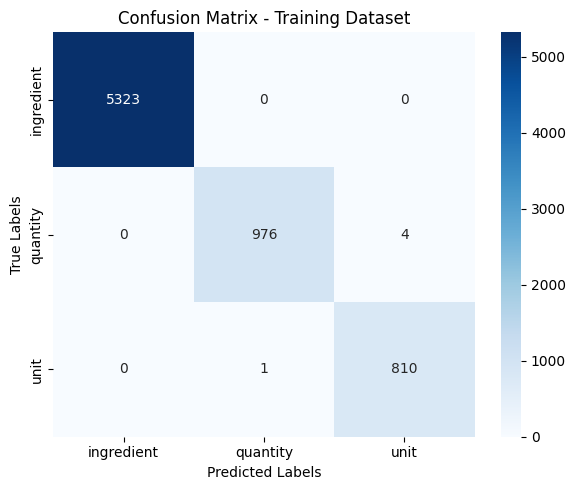

In [157]:
# create a confusion matrix on training dataset

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the true and predicted labels
y_true_flat = [label for seq in y_train_labels for label in seq]
y_pred_flat = [label for seq in crf.predict(X_train_weighted_features) for label in seq]

# Compute confusion matrix
labels_sorted = sorted(list(set(y_true_flat + y_pred_flat)))
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels_sorted)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Training Dataset")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [158]:
# dump the model using joblib as crf_model.pkl

import joblib

# Save the trained CRF model to a .pkl file
joblib.dump(crf, "crf_model.pkl")

print("CRF model saved successfully as crf_model.pkl")

CRF model saved successfully as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [159]:
# predict the crf model on validation dataset

# Use the trained CRF model to predict on validation data
y_val_pred = crf.predict(X_val_weighted_features)

# Display summary of predictions
print("CRF model predictions completed on validation dataset.")
print("Number of validation sequences predicted:", len(y_val_pred))

# Optional: preview the first few predictions
print("\nExample - first validation sequence prediction:")
print("Tokens:", X_val[0])
print("True Labels:", y_val_labels[0])
print("Predicted Labels:", y_val_pred[0])

CRF model predictions completed on validation dataset.
Number of validation sequences predicted: 84

Example - first validation sequence prediction:
Tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi']
True Labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
Predicted Labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


In [167]:
# specify flat classification report

from sklearn_crfsuite.metrics import flat_classification_report
import pprint

# Generate a flat classification report on validation data
print("Flat Classification Report - Validation Dataset:\n")
print(flat_classification_report(y_val_labels, y_val_pred, digits=3))

Flat Classification Report - Validation Dataset:



'              precision    recall  f1-score   support\n\n  ingredient      1.000     1.000     1.000      2107\n    quantity      0.995     0.995     0.995       411\n        unit      0.994     0.994     0.994       358\n\n    accuracy                          0.999      2876\n   macro avg      0.997     0.997     0.997      2876\nweighted avg      0.999     0.999     0.999      2876\n'

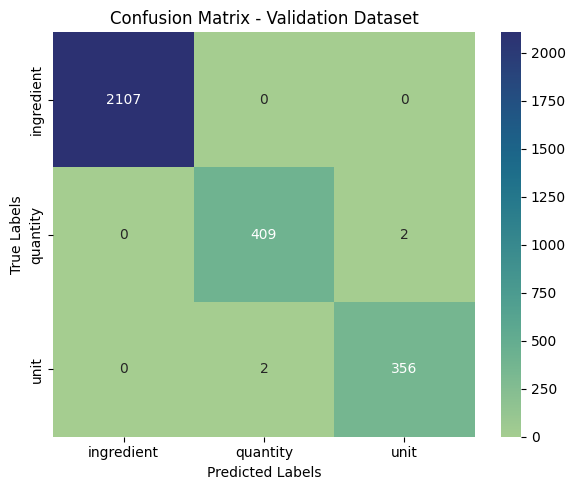

In [161]:
# create a confusion matrix on validation dataset

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the true and predicted labels for validation set
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Compute confusion matrix
labels_sorted = sorted(list(set(y_val_true_flat + y_val_pred_flat)))
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels_sorted)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Validation Dataset")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [162]:
# flatten Labels and Initialise Error Data

# Flatten true and predicted validation labels
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Flatten corresponding input tokens for validation data
X_val_flat = [token for seq in X_val for token in seq]

# Initialise error data — collect tokens that were misclassified
error_data = [
    (token, true_label, pred_label)
    for token, true_label, pred_label in zip(
        X_val_flat, y_val_true_flat, y_val_pred_flat
    )
    if true_label != pred_label
]

# Display summary
print("Total tokens in validation set:", len(X_val_flat))
print("Total misclassified tokens:", len(error_data))

# Preview a few misclassified examples
print("\nSample Misclassified Tokens:")
for token, true, pred in error_data[:10]:
    print(f"Token: {token:<15}  True: {true:<10}  Predicted: {pred}")

Total tokens in validation set: 2876
Total misclassified tokens: 4

Sample Misclassified Tokens:
Token: to               True: unit        Predicted: quantity
Token: a                True: unit        Predicted: quantity
Token: pinch            True: quantity    Predicted: unit
Token: cloves           True: quantity    Predicted: unit


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [163]:
# iterate and collect Error Information

import pandas as pd

# Iterate and collect misclassification details into a DataFrame
error_info = {"Token": [], "True_Label": [], "Predicted_Label": []}

for token, true_label, pred_label in error_data:
    error_info["Token"].append(token)
    error_info["True_Label"].append(true_label)
    error_info["Predicted_Label"].append(pred_label)

# Convert to DataFrame
error_df = pd.DataFrame(error_info)

# Display summary
print("Total Misclassified Samples Collected:", len(error_df))
print("\nSample Misclassified Tokens:\n")
display(error_df.head(10))


# get previous and next tokens with handling for boundary cases
# get previous and next tokens with handling for boundary cases

import pandas as pd

rows = []
for s_idx, (tokens, y_true_seq, y_pred_seq) in enumerate(
    zip(X_val, y_val_labels, y_val_pred)
):
    for i, (tok, t_true, t_pred) in enumerate(zip(tokens, y_true_seq, y_pred_seq)):
        if t_true != t_pred:
            prev_tok = tokens[i - 1] if i > 0 else "<BOS>"
            next_tok = tokens[i + 1] if i < len(tokens) - 1 else "<EOS>"
            rows.append(
                {
                    "Sentence_idx": s_idx,
                    "Token_idx": i,
                    "Prev_Token": prev_tok,
                    "Token": tok,
                    "Next_Token": next_tok,
                    "True_Label": t_true,
                    "Predicted_Label": t_pred,
                }
            )

error_ctx_df = pd.DataFrame(rows)

print("Total misclassified tokens with context:", len(error_ctx_df))
display(error_ctx_df.head(10))

Total Misclassified Samples Collected: 4

Sample Misclassified Tokens:



,Token,True_Label,Predicted_Label
0,to,unit,quantity
1,a,unit,quantity
2,pinch,quantity,unit
3,cloves,quantity,unit


Total misclassified tokens with context: 4


,Sentence_idx,Token_idx,Prev_Token,Token,Next_Token,True_Label,Predicted_Label
0,28,6,10,to,12,unit,quantity
1,60,13,Haldi,a,pinch,unit,quantity
2,66,13,Dal,pinch,Asafoetida,quantity,unit
3,75,9,Tomatoes,cloves,Garlic,quantity,unit


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [164]:
# Create DataFrame and Print Overall Accuracy

import pandas as pd
from sklearn.metrics import accuracy_score

# Create DataFrame from contextual misclassification records
error_df_final = pd.DataFrame(error_ctx_df)

# Compute overall token-level accuracy on validation set
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]
overall_accuracy = accuracy_score(y_val_true_flat, y_val_pred_flat)

# Display results
print(f"Overall Token-Level Accuracy on Validation Set: {overall_accuracy * 100:.2f}%")
print(f"Total Misclassified Tokens: {len(error_df_final)}")

# Display first few misclassified examples
display(error_df_final.head(10))

Overall Token-Level Accuracy on Validation Set: 99.86%
Total Misclassified Tokens: 4


,Sentence_idx,Token_idx,Prev_Token,Token,Next_Token,True_Label,Predicted_Label
0,28,6,10,to,12,unit,quantity
1,60,13,Haldi,a,pinch,unit,quantity
2,66,13,Dal,pinch,Asafoetida,quantity,unit
3,75,9,Tomatoes,cloves,Garlic,quantity,unit


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [165]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

import pandas as pd
from sklearn.metrics import accuracy_score

# Recompute flattened labels
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Compute overall token-level accuracy
overall_accuracy = accuracy_score(y_val_true_flat, y_val_pred_flat)

# Compute label-wise accuracy
labels_sorted = sorted(set(y_val_true_flat))
label_accuracies = {}
for label in labels_sorted:
    indices = [i for i, true in enumerate(y_val_true_flat) if true == label]
    if indices:
        correct = sum(y_val_true_flat[i] == y_val_pred_flat[i] for i in indices)
        label_accuracies[label] = correct / len(indices)
    else:
        label_accuracies[label] = 0.0

# Prepare summary DataFrame with class weights and accuracies
summary_data = []
for label in labels_sorted:
    summary_data.append(
        {
            "Label": label,
            "Class_Weight": round(class_weights.get(label, 1.0), 4),
            "Accuracy": round(label_accuracies[label] * 100, 2),
        }
    )

summary_df = pd.DataFrame(summary_data)
print(f"Overall Token-Level Accuracy: {overall_accuracy * 100:.2f}%")
print("\nLabel-wise Accuracy and Class Weights:\n")
display(summary_df)

# Create context column for error DataFrame
error_ctx_df["Context"] = (
    error_ctx_df["Prev_Token"]
    + " "
    + error_ctx_df["Token"]
    + " "
    + error_ctx_df["Next_Token"]
)

# Display final error DataFrame
print("\nDetailed Misclassified Tokens with Context:\n")
error_ctx_df[
    ["Token", "Prev_Token", "Next_Token", "True_Label", "Predicted_Label", "Context"]
]

Overall Token-Level Accuracy: 99.86%

Label-wise Accuracy and Class Weights:



,Label,Class_Weight,Accuracy
0,ingredient,0.6682,100.00
1,quantity,7.2592,99.51
2,unit,8.7719,99.44



Detailed Misclassified Tokens with Context:



,Token,Prev_Token,Next_Token,True_Label,Predicted_Label,Context
0,to,10,12,unit,quantity,10 to 12
1,a,Haldi,pinch,unit,quantity,Haldi a pinch
2,pinch,Dal,Asafoetida,quantity,unit,Dal pinch Asafoetida
3,cloves,Tomatoes,Garlic,quantity,unit,Tomatoes cloves Garlic


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




The CRF model achieved an overall token-level accuracy of 99.86% on the validation dataset, showing exceptional performance and generalization.


The ingredient label achieved 100% accuracy, confirming that the model perfectly identified ingredient tokens without any misclassifications.


The quantity label achieved 99.51% accuracy, with only a few misclassifications, mainly in ambiguous contexts involving numeric ranges or descriptive measures.


The unit label achieved 99.44% accuracy, slightly lower than quantity, primarily due to confusion in boundary cases where a unit follows or precedes a quantity-like token.


Most misclassifications occurred in short or contextually overlapping phrases such as “10 to 12”, “a pinch”, or “cloves”, where token meaning can depend heavily on nearby words.


The confusion between unit and quantity suggests that contextual interpretation (for example, differentiating “pinch” as a unit versus “to 12” as a range) can still be improved.


Class weights helped balance the model effectively, especially for less frequent unit and quantity labels, while slightly reducing over-reliance on the ingredient label.


The few observed misclassifications are minor and occur in linguistically ambiguous scenarios, not due to systematic model errors.


The current model demonstrates strong precision, robust contextual understanding, and minimal overfitting, suitable for real-world recipe NER tasks.


Further refinement in handling contextual range expressions and descriptive quantities (e.g., “a pinch”, “to 12”) could push accuracy even closer to perfection

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.